In [7]:
import os
import numpy as np
import pandas as pd
from time import time
from utils import custom_preprocessing, dependencies

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = 20

data_dir = "/home/stavros/DATA/AirbnbReviews"
#data_dir = "D:/"

Load preprocessed data for Santorini, Mykonos and Rhodes

In [8]:
area = "south_aegean"
area_dir = os.path.join(data_dir, area)

island_samples = {"Santorini": 100266, "Mykonos": 40866, "Rhodes": 25566}

island_reviews = {k: pd.read_pickle(os.path.join(area_dir, "reviews_with_aspects_{}_{}samples.pkl".format(k, n)))
                  for k, n in island_samples.items()}

for k, r in island_reviews.items():
    print("{}: {}".format(k, r.shape))

print()
# Check how many reviews have no identified aspects (percentage)
for k, r in island_reviews.items():
    print("{}: {}".format(k, pd.isnull(r["aspects"]).sum() * 100.0 / len(r)))
    
# Clean reviews
for k, r in island_reviews.items():
    island_reviews[k] = r[pd.notnull(r["aspects"])]

Santorini: (100266, 9)
Mykonos: (40866, 9)
Rhodes: (25566, 9)

Santorini: 16.34751560848144
Mykonos: 16.926050995937942
Rhodes: 28.737385590237032


In [9]:
import gensim
google_vec_file = os.path.join(data_dir, "GoogleNews-vectors-negative300.bin.gz")
word2vec = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True, limit=200000)
word2vec

In [10]:
from utils import aspect_tools
island_aspects = {k: aspect_tools.collect_aspects(r) for k, r in island_reviews.items()}

In [11]:
mykonos_matrix = aspect_tools.DistanceMatrix.calculate(word2vec, island_aspects["Mykonos"])
for cut_off in [0.1, 0.2, 0.3, 0.4, 0.5]:
    print(mykonos_matrix.words_closer_than(cut_off))

Calculating matrix with 1772 words.
2
72
364
947
2593


In [12]:
santorini_matrix = aspect_tools.DistanceMatrix.calculate(word2vec, island_aspects["Santorini"])
for cut_off in [0.1, 0.2, 0.3, 0.4, 0.5]:
    print(santorini_matrix.words_closer_than(cut_off))

Calculating matrix with 2991 words.
7
158
716
2007
5867


In [13]:
rhodes_matrix = aspect_tools.DistanceMatrix.calculate(word2vec, island_aspects["Rhodes"])
for cut_off in [0.1, 0.2, 0.3, 0.4, 0.5]:
    print(rhodes_matrix.words_closer_than(cut_off))

Calculating matrix with 1439 words.
1
58
292
776
2085


In [14]:
island_aspects_merged = {
    "Santorini": santorini_matrix.merge_words(cut_off=0.3),
    "Mykonos": mykonos_matrix.merge_words(cut_off=0.3),
    "Rhodes": rhodes_matrix.merge_words(cut_off=0.3)}

In [15]:
island_aspects_merged = {k: aspect_tools.manual_word_merge(a, "view", "views") 
                         for k, a in island_aspects_merged.items()}

In [29]:
for k, a in island_aspects.items():
    print(k)
    print(len(island_aspects_merged[k]), len(a))
    print(island_aspects_merged[k].most_common(10))

Santorini
2468 8120
[('host', 34108), ('place', 22869), ('view', 20553), ('location', 16487), ('stay', 10018), ('house', 8027), ('cave', 6912), ('room', 6661), ('apartment', 6243), ('time', 5575)]
Mykonos
1484 4874
[('host', 13214), ('place', 8264), ('view', 7724), ('location', 6833), ('stay', 3704), ('apartment', 2791), ('house', 2605), ('room', 2313), ('time', 2309), ('beach', 1909)]
Rhodes
1208 4297
[('host', 7220), ('place', 4109), ('location', 3615), ('apartment', 2934), ('stay', 2120), ('house', 2089), ('time', 1407), ('view', 1341), ('beach', 1086), ('everything', 940)]


Find common words for plot

<IPython.core.display.Javascript object>


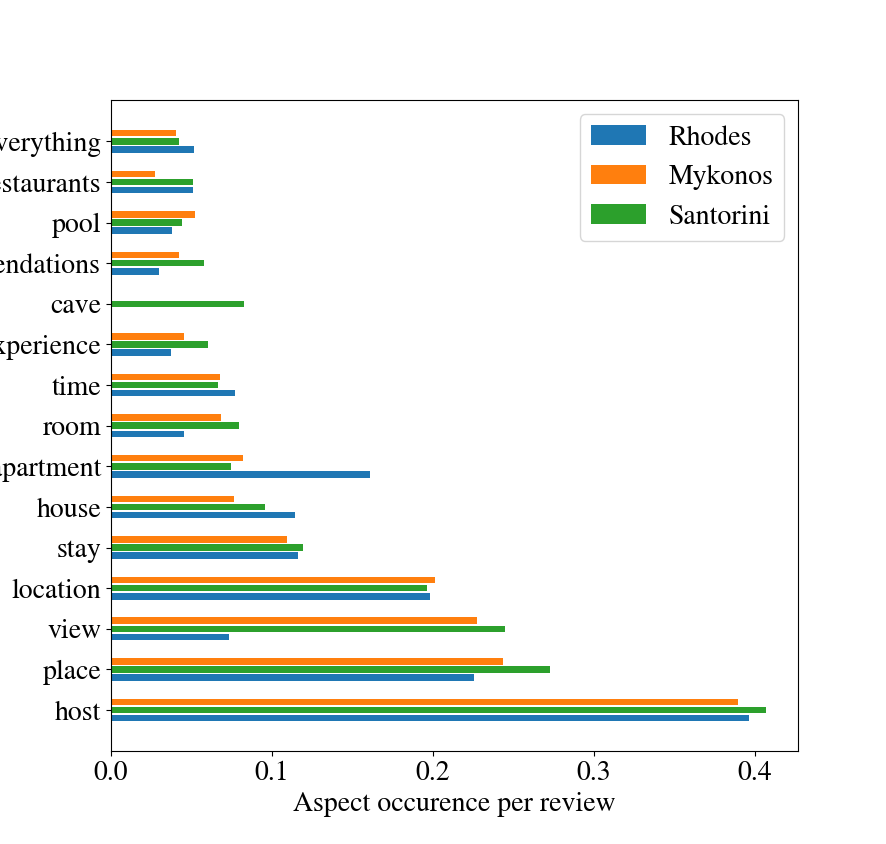

In [16]:
import collections
bar_plot_word_index0 = 0
bar_plot_word_index1 = 15

collective_aspects = collections.Counter()
for a in island_aspects_merged.values():
    collective_aspects += a


bar_plot_words = collective_aspects.most_common()[bar_plot_word_index0: bar_plot_word_index1]
bar_plot_words = [word for word, _ in bar_plot_words]
y_pos = np.array([5*i for i, _ in enumerate(bar_plot_words)])
bar_plot_counts = {k: np.array([a[word] for word in bar_plot_words]) / len(island_reviews[k]) 
                   for k, a in island_aspects_merged.items()}

cp = sns.color_palette()

plt.figure(figsize=(10, 10))
plt.barh(y_pos - 1, bar_plot_counts["Rhodes"], color=cp[0], label="Rhodes")
plt.barh(y_pos + 1, bar_plot_counts["Mykonos"], color=cp[1], label="Mykonos")
plt.barh(y_pos, bar_plot_counts["Santorini"], color=cp[2], label="Santorini")
plt.yticks(y_pos, bar_plot_words)
plt.xlabel("Aspect occurence per review")
plt.legend()
plt.show()    

<IPython.core.display.Javascript object>


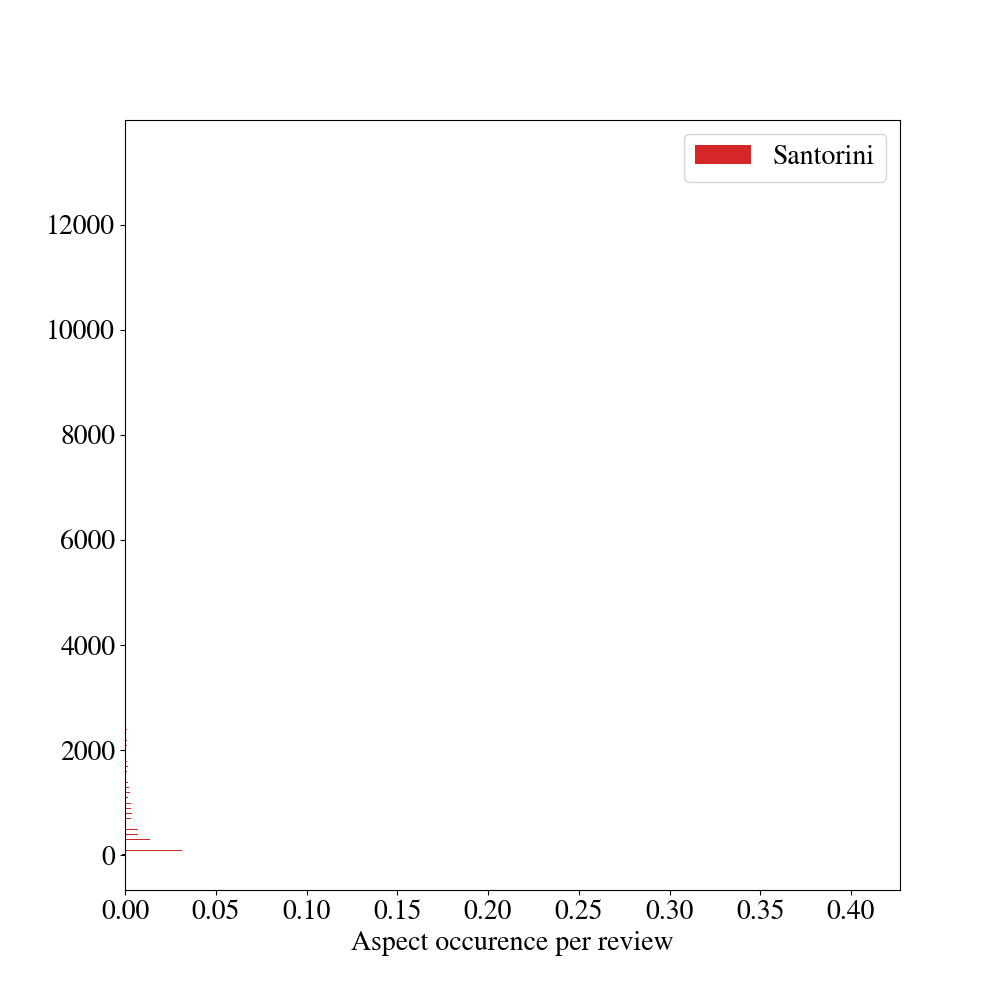

interactive(children=(IntSlider(value=0, description='first_word', max=1), IntSlider(value=10, description='n_…

In [25]:
%matplotlib notebook
import ipywidgets
import collections

bar_plot_n_words = 15


collective_aspects = collections.Counter()
for a in island_aspects_merged.values():
    collective_aspects += a
bar_plot_words = collective_aspects.most_common()
bar_plot_words = [word for word, _ in bar_plot_words]

cp = sns.color_palette()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
y_pos = np.zeros(10)
bar3 = ax.barh(y_pos, y_pos, color=cp[3], label="Santorini")
ax.set_xlabel("Aspect occurence per review")
ax.legend()


def update(first_word, n_words=10):
    indexed_words = bar_plot_words[first_word: first_word + n_words]
    y_pos = np.array([5*i for i, _ in enumerate(indexed_words)])
    bar_plot_counts = {k: np.array([a[word] for word in indexed_words]) / len(island_reviews[k]) 
                       for k, a in island_aspects_merged.items()}
    
    bar3 = ax.barh(y_pos, bar_plot_counts["Santorini"], color=cp[3], label="Santorini")
    ax.set_yticks(y_pos, bar_plot_words)
    
    
ipywidgets.interact(update, first_word=0, n_words=10);

<IPython.core.display.Javascript object>


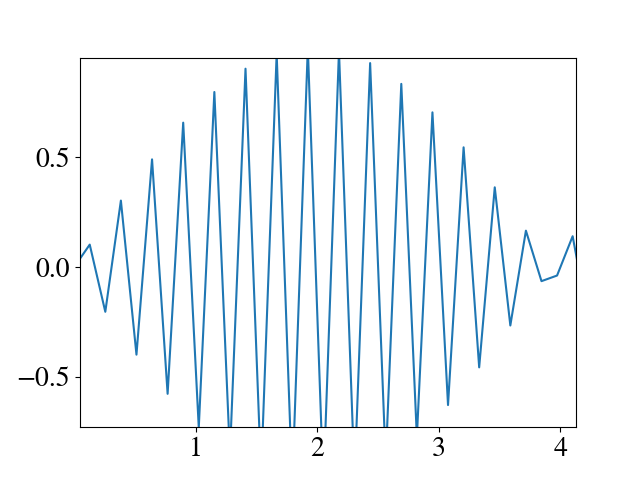

interactive(children=(FloatSlider(value=10.0, description='w', max=30.0, min=-10.0), Output()), _dom_classes=(…

In [5]:
%matplotlib notebook
import ipywidgets

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(w = 1.0):
    line.set_ydata(np.sin(w * x))
    fig.canvas.draw_idle()

ipywidgets.interact(update, w=10.0);